# Electrocardiography (ECG) processing pipeline in *Python*

Created on 20201.7.10 by Rain. This notebook this for the demo of ECG data processing

The raw data we will use were obtained from BIOPAC MP160 with a sampling rate of 2000Hz, and first exported in a mat format for segmentation in MATLAB.

Generally, I think the biosinal processing pipeline are basically the same for different kind of data, while the feature extraction can be different. ECG signal are very important and different physiological indices can be derived from ECG,such as (1) Heartbeat (2)Heart Rate Variability(HRV) (3) ECG-derived respiration (EDR) (4) 

In this script, the ECG analysis are mainly conducted by neurokit2, for preprocessing and feature extraction.
Overview:
Step 1: Import the raw ECG data
Step 2: Flatten the data array & Downsapmling accrodingly(if needed) 
Step 3: Clean the signal
Step 4: 

# Part 1: Let's go through the processing pipeline step by step

## Step 1: Import raw data

In [2]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline
data = loadmat('D:/2021_Data_Analysis/2021_VR_Emotion/sub_001_helpless_1.mat')
plt.rcParams['figure.figsize'] = [15, 9]  # Bigger images
plt.rcParams['font.size']= 13

In [3]:
# Let's take a look of our current dataset
print(data);print(type(data));print(data.keys());

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Jun 21 13:57:21 2021', '__version__': '1.0', '__globals__': [], 'ecg_hl1': array([[0.07568359],
       [0.07614136],
       [0.0769043 ],
       ...,
       [0.04180908],
       [0.04226685],
       [0.04364014]]), 'eda_hl1': array([[11.65466267],
       [11.6592403 ],
       [11.65466267],
       ...,
       [11.64703327],
       [11.64703327],
       [11.64398151]]), 'emg_hl1': array([[ 0.00457764],
       [ 0.00030518],
       [-0.01846313],
       ...,
       [-0.00091553],
       [ 0.00045776],
       [ 0.00091553]]), 'emgc_hl1': array([[1.08489990e-04],
       [9.27734375e-05],
       [8.66699219e-05],
       ...,
       [4.30297852e-05],
       [3.71551514e-05],
       [3.39508057e-05]]), 'hr_hl1': array([[83.79888268],
       [83.79888268],
       [83.79888268],
       ...,
       [85.04606662],
       [85.04606662],
       [85.04606662]]), 'ppg_hl1': array([[-0.00091553],
       [-0.00091553],
       [-0.

In [11]:
# Primarily, we can see that within each mat file, the multimodality physiological data were stored into a numpy array individually

## Step 2: Flatten the data array & Downsampling accrodingly(if needed)

In [4]:
# You can inspect the dimension of the data befor and after the flatten
ecg=data['ecg_hl1']#Extract the ECG signal;
ecg.shape;
ecg=np.ndarray.flatten(ecg);
ecg.shape ## For downsampling and further processing, we should flatten the 2-D array into a 1-D array

(216001,)

In [13]:
#ecg = nk.signal_resample(ecg, method="numpy",sampling_rate=2000, desired_sampling_rate=100)# Here the neurokit downssampling functionwas used, in the manner of numpy downsampling

In [5]:
ecg.shape

(216001,)

## Step 3: Clean the raw ECG Signal

In [6]:
# Clean the ECG raw signal by using the ecg_clean function
ecg_cleaned=nk.ecg_clean(ecg,sampling_rate=2000,method="neurokit")

## Step 4: 
## (1) Find the R peaks of the cleaned ECG signals 
## (2) Locate and Delineate the P/T-peaks & QRS complex Complex

In [7]:
# By using the ecg_peaks function, we can locate the R peaks of the cleaned ECG signal. Another low-level function ecg_findpeaks is a used by this function
instant_peaks,rpeaks=nk.ecg_peaks(ecg_cleaned,sampling_rate=2000,method="neurokit",correct_artifacts=True)

In [36]:
instant_peaks

,ECG_R_Peaks
0,0
1,0
2,0
3,0
4,0
...,...
215996,0
215997,0
215998,0
215999,0


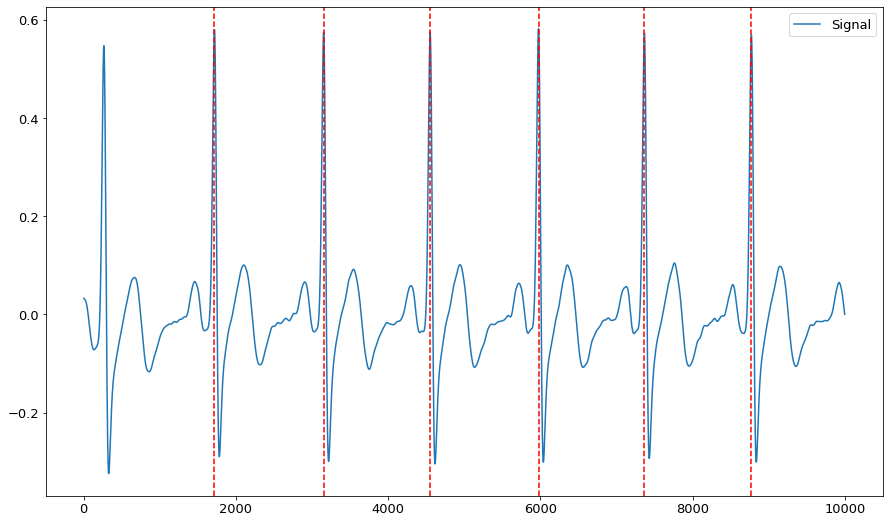

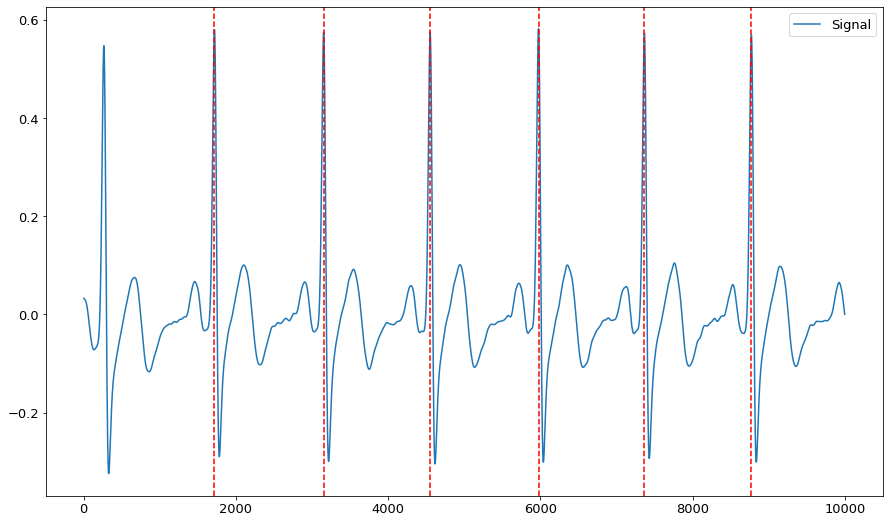

In [9]:
nk.events_plot(rpeaks['ECG_R_Peaks'][:6], ecg_cleaned[:10000])

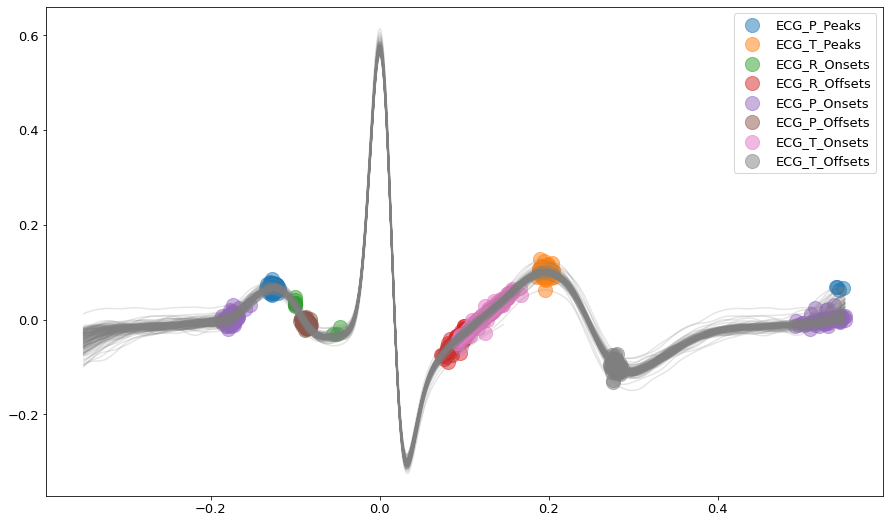

In [11]:
# Let's delineate the PQST compex and have a look
PQRST, waves = nk.ecg_delineate(ecg_cleaned, rpeaks, sampling_rate=2000, method="cwt",show=True,show_type='all')

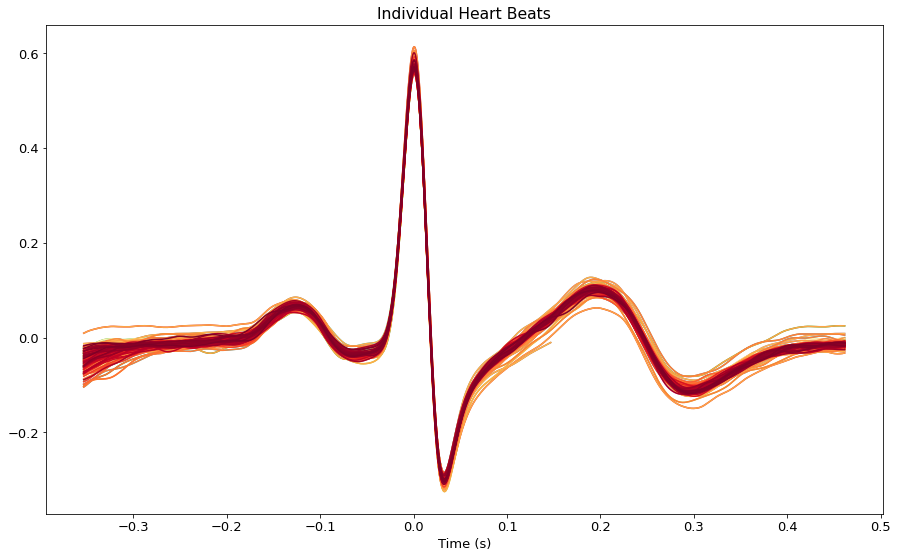

In [38]:
# Plotting all the heart beats
epochs = nk.ecg_segment(ecg_cleaned,  sampling_rate=2000, show=True)

## Step 5: Compute the cardiac phase and signal rate from peaks

In [12]:
cardiac_phase=nk.ecg_phase(ecg_cleaned,rpeaks=rpeaks,delineate_info=waves, sampling_rate=2000)

In [21]:
cardiac_phase

,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,NaN,0.0,NaN,0.0
1,NaN,0.0,NaN,0.0
2,NaN,0.0,NaN,0.0
3,NaN,0.0,NaN,0.0
4,NaN,0.0,NaN,0.0
...,...,...,...,...
215996,NaN,0.0,NaN,0.0
215997,NaN,0.0,NaN,0.0
215998,NaN,0.0,NaN,0.0
215999,NaN,0.0,NaN,0.0


In [13]:
rate=nk.ecg_rate(rpeaks, sampling_rate=2000, desired_length=len(ecg_cleaned), interpolation_method='monotone_cubic')

In [14]:
rate

array([82.99453245, 82.99453245, 82.99453245, ..., 85.10638298,
       85.10638298, 85.10638298])

## Step 6: Compute the quality of the ECG signal

In [15]:
quality=nk.ecg_quality(ecg_cleaned, sampling_rate=2000)

In [16]:
quality

array([0.69145343, 0.69145343, 0.69145343, ..., 0.        , 0.        ,
       0.        ])

## Step 7: Obtain the ECG derived respiration(EDR)

In [28]:
edr=nk.ecg_rsp(rate,sampling_rate=2000)

In [29]:
edr

array([-6.56162188e-01, -6.56479810e-01, -6.56797403e-01, ...,
       -1.40392739e-06, -1.17098019e-06, -9.65360091e-07])

## Step 8: Aggregate the result and plot

In [30]:
signals = pd.DataFrame({"ECG_Raw": ecg,
                            "ECG_Clean": ecg_cleaned,
                            "ECG_Rate": rate,
                            "ECG_Quality": quality,"ECG_EDR":edr})

signals = pd.concat([signals, instant_peaks,PQRST,cardiac_phase], axis=1)

In [31]:
signals # Have a look of all the result we have obtained 

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_EDR,ECG_R_Peaks,ECG_P_Peaks,ECG_T_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_P_Onsets,ECG_P_Offsets,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,0.075684,0.032637,82.994532,0.691453,-6.561622e-01,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
1,0.076141,0.032548,82.994532,0.691453,-6.564798e-01,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
2,0.076904,0.032458,82.994532,0.691453,-6.567974e-01,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3,0.077972,0.032363,82.994532,0.691453,-6.571150e-01,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
4,0.078278,0.032261,82.994532,0.691453,-6.574325e-01,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215996,0.039825,-0.012715,85.106383,0.000000,-1.958610e-06,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
215997,0.041046,-0.012162,85.106383,0.000000,-1.665904e-06,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
215998,0.041809,-0.011610,85.106383,0.000000,-1.403927e-06,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
215999,0.042267,-0.011056,85.106383,0.000000,-1.170980e-06,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0


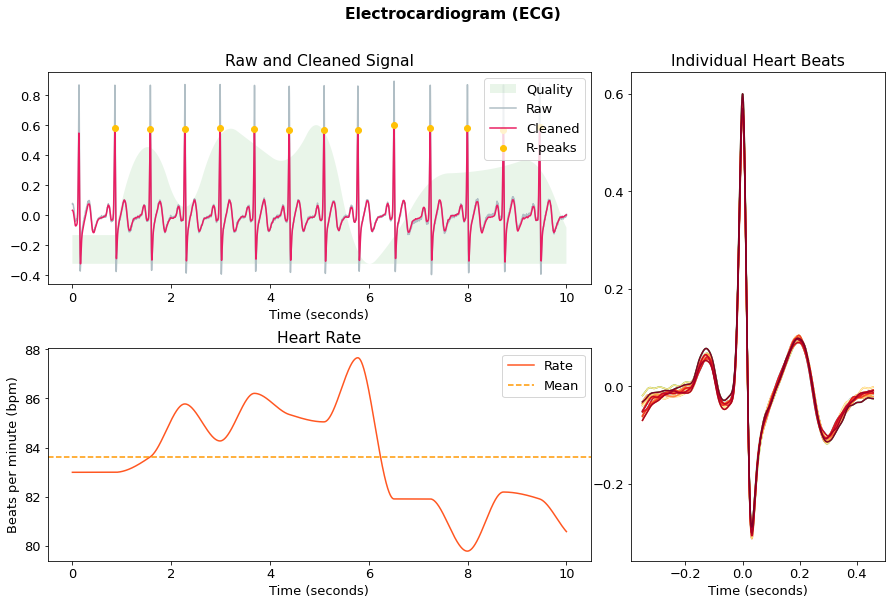

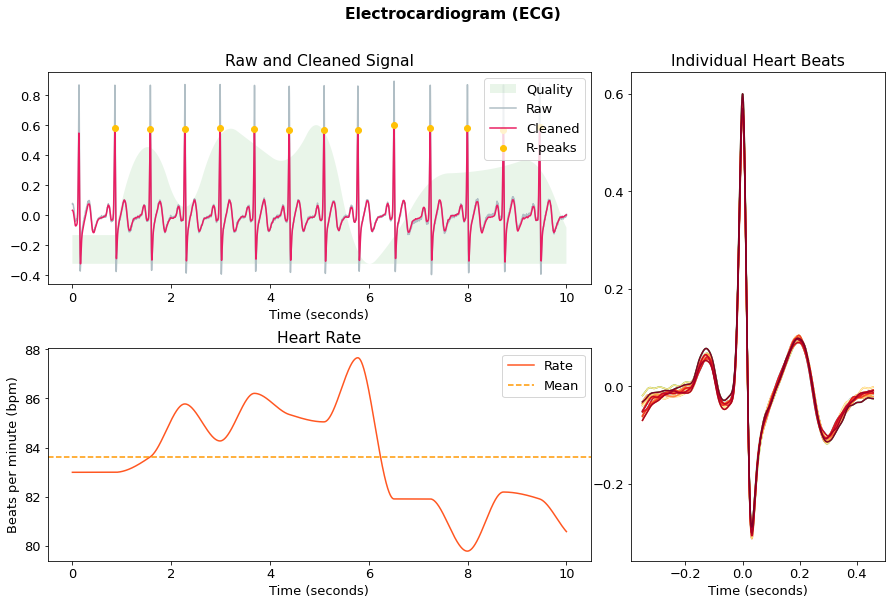

In [27]:
nk.ecg_plot(signals[0:20000],sampling_rate=2000)# Define the timewindow of plot and the sampling rate

## Step 9: Feature extrction(interval-related in this case)

In [33]:
ecg_features=nk.ecg_intervalrelated(signals,sampling_rate=2000)

In [34]:
ecg_features

,ECG_Rate_Mean,HRV_RMSSD,HRV_MeanNN,HRV_SDNN,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,...,HRV_Ca,HRV_SDNNd,HRV_SDNNa,HRV_ApEn,HRV_SampEn,HRV_MSE,HRV_CMSE,HRV_RCMSE,HRV_DFA,HRV_CorrDim
0,82.996215,20.97492,722.939189,24.105487,21.046457,0.033344,0.029013,726.0,26.6868,0.036759,...,0.454381,17.848161,16.287659,0.770667,1.909543,0.0,1.339362,1.816859,1.045678,1.505713


# Part 2: Let's customize our own function for ECG processing